In [1]:
import cv2
import numpy as np 
import time 
import os 
import mediapipe as mp

In [2]:
image=cv2.imread(r"C:\Users\pc\OneDrive\Desktop\smart board\tool_bar.png")
image = cv2.resize(image, (1280, 125))
image = cv2.flip(image, 1)

In [3]:
image.shape

(125, 1280, 3)

In [4]:
mp_drawing = mp.solutions.drawing_utils
mp_hands = mp.solutions.hands

In [5]:
from transformers import TrOCRProcessor, VisionEncoderDecoderModel
from PIL import Image
from IPython.display import display
import numpy as np

In [6]:
processor =TrOCRProcessor.from_pretrained("microsoft/trocr-large-handwritten")

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


In [7]:
model = VisionEncoderDecoderModel.from_pretrained("microsoft/trocr-large-handwritten")

Config of the encoder: <class 'transformers.models.vit.modeling_vit.ViTModel'> is overwritten by shared encoder config: ViTConfig {
  "attention_probs_dropout_prob": 0.0,
  "encoder_stride": 16,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.0,
  "hidden_size": 1024,
  "image_size": 384,
  "initializer_range": 0.02,
  "intermediate_size": 4096,
  "layer_norm_eps": 1e-12,
  "model_type": "vit",
  "num_attention_heads": 16,
  "num_channels": 3,
  "num_hidden_layers": 24,
  "patch_size": 16,
  "pooler_act": "tanh",
  "pooler_output_size": 1024,
  "qkv_bias": false,
  "torch_dtype": "float32",
  "transformers_version": "4.51.0"
}

Config of the decoder: <class 'transformers.models.trocr.modeling_trocr.TrOCRForCausalLM'> is overwritten by shared decoder config: TrOCRConfig {
  "activation_dropout": 0.0,
  "activation_function": "gelu",
  "add_cross_attention": true,
  "attention_dropout": 0.0,
  "bos_token_id": 0,
  "classifier_dropout": 0.0,
  "cross_attention_hidden_size": 1024,
  "d_

In [8]:
def show_image(image_path):
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) 
    display(Image.fromarray(img)) 
    return img

def ocr_image(image):
    image = Image.fromarray(image) # Convert to PIL image
    pixel_values = processor(images=image, return_tensors="pt").pixel_values
    generated_ids = model.generate(pixel_values)
    generated_text = processor.batch_decode(generated_ids, skip_special_tokens=True)[0]
    return generated_text


In [9]:
import re

def solve_equation(equation_str):
    try:
        equation_str = equation_str.replace("x", "*")
        equation_str = equation_str.replace("X", "*")
        equation_str = equation_str.replace("=", "==")  
        numbers_operators = re.findall(r"(\d+\.?\d*|\+|-|\*|/|=|==)", equation_str)
        result = 0.0
        current_op = "+"
        for item in numbers_operators:
            if item.isdigit() or ("." in item and item.replace(".", "").isdigit()):
                num = float(item)
                if current_op == "+":
                    result += num
                elif current_op == "-":
                    result -= num
                elif current_op == "*":
                    result *= num
                elif current_op == "/":
                    if num == 0:
                        return "Division by zero error"
                    result /= num
            elif item in ("+", "-", "*", "/"):
                current_op = item
            elif item == "=" or item == "==":
                pass  
        return result

    except (ValueError, TypeError, IndexError, AttributeError):
        return "Invalid equation"



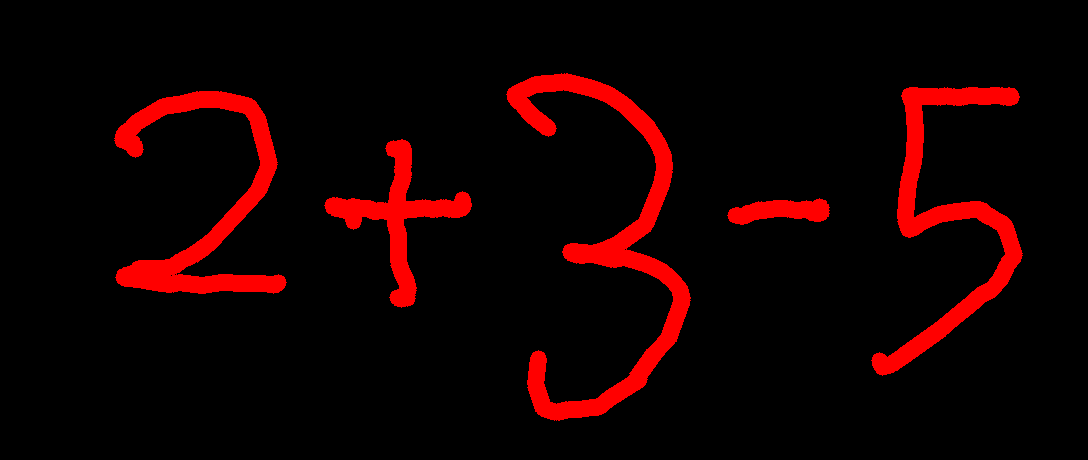

2-3-5 .


In [10]:
img5 = show_image(r"C:\Users\pc\OneDrive\Desktop\smart board\Screenshot 2025-04-07 113045.png")
print(ocr_image(img5))

In [11]:
ocr_result = ocr_image(img5)  
solution = solve_equation(ocr_result)
print(f"OCR Result: {ocr_result}")
print(f"Solution: {solution}")


OCR Result: 2-3-5 .
Solution: -6.0


In [15]:
cap=cv2.VideoCapture(0)
#cap.set()
cap.set(cv2.CAP_PROP_FRAME_WIDTH, 1280)  # Width
cap.set(cv2.CAP_PROP_FRAME_HEIGHT, 720)  # Height
color=(0,0,255)
thickness=15
eraser_thickness=100
xp,yp=0,0

drwaing_img=np.zeros((720,1280,3),np.uint8)

with mp_hands.Hands(min_detection_confidence=0.8, min_tracking_confidence=0.5) as hands: 
    while True:
        success,img=cap.read()
        img[0:125,0:1280]=image
    
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.flip(img, 1)
        
        img.flags.writeable = False
        results = hands.process(img)
        img.flags.writeable = True
        img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
        #print(results)
        
        lmlist=[]
        tipids = [4, 8, 12, 16, 20]
        
        if results.multi_hand_landmarks:
            for num, hand in enumerate(results.multi_hand_landmarks):
                mp_drawing.draw_landmarks(img, hand, mp_hands.HAND_CONNECTIONS)
                
                for hand_landmarks in results.multi_hand_landmarks:
                    for id, lm in enumerate(hand_landmarks.landmark):
                        h, w, c = img.shape  # Get image dimensions
                        cx, cy = int(lm.x * w), int(lm.y * h)  # Convert normalized coordinates to pixel values
                        lmlist.append((id, cx, cy))  # Append landmark ID and position
                
        '''    
        if len(lmlist)!=0:
            #print(lmlist)
            print(lmlist[8])
            x1,y1=lmlist[8][1:]
            x2,y2=lmlist[12][1:]
        '''
        
        if len(lmlist) != 0:
            fingers = []
            
            # Thumb (compare x-coordinates because thumb moves horizontally)
            if lmlist[tipids[0]][1] < lmlist[tipids[0] - 1][1]:
                fingers.append(1)
            else:
                fingers.append(0)
            
            # Other four fingers (compare y-coordinates because they move vertically)
            for id in range(1, 5):
                if lmlist[tipids[id]][2] < lmlist[tipids[id] - 2][2]:
                    fingers.append(1)
                else:
                    fingers.append(0)
            
            #print(f"Fingers: {fingers}")
            x1, y1 = lmlist[8][1], lmlist[8][2]
            x2, y2 = lmlist[12][1], lmlist[12][2]

            if fingers[1] and fingers[2]:
                xp,yp=0,0
                #print("Selection Mode")
                if y1<125:
                    if 280<x1<378:
                        print("Pencil")
                        color=(0,0,255)
                    elif  490<x1<655:
                        print("Eraser")
                        color=(0,0,0)
                    elif 785<x1<970:
                        print("Clear")
                        drwaing_img = np.zeros((720, 1280, 3), np.uint8)
                        #color=(0,0,255)
                    elif 1000<x1<1190:
                        print("Solve")
                        #color=(0,255,0)
                        ocr_img = drwaing_img.copy()
                        ocr_img_gray = cv2.cvtColor(ocr_img, cv2.COLOR_BGR2GRAY)
                        _, ocr_img_thresh = cv2.threshold(ocr_img_gray, 50, 255, cv2.THRESH_BINARY)
                        ocr_img_rgb = cv2.cvtColor(ocr_img_thresh, cv2.COLOR_GRAY2RGB)
                        pil_img = Image.fromarray(ocr_img_rgb)
            
                        # OCR
                        pixel_values = processor(images=pil_img, return_tensors="pt").pixel_values
                        generated_ids = model.generate(pixel_values)
                        generated_text = processor.batch_decode(generated_ids, skip_special_tokens=True)[0]
                        print(f"OCR Result: {generated_text}")

                        solution = solve_equation(generated_text)
                        print(f"Solution: {solution}")

                        # Optional: show on screen
                        cv2.putText(img, f'{generated_text} = {solution}', (50, 680), cv2.FONT_HERSHEY_SIMPLEX, 1.5, (0,255,0), 3)
                cv2.rectangle(img,(x1,y1-25),(x2,y2+25),color,cv2.FILLED)

                        
            else:
                #print("Drewing Mode")
                cv2.circle(img,(x1,y1),15,color,cv2.FILLED)
                if xp==0 and yp==0:
                    xp,yp=x1,y1
                if color==(0,0,0):
                    cv2.line(img,(xp,yp),(x1,y1),color,eraser_thickness)
                    cv2.line(drwaing_img,(xp,yp),(x1,y1),color,eraser_thickness)
                else:
                    cv2.line(img,(xp,yp),(x1,y1),color,thickness)
                    cv2.line(drwaing_img,(xp,yp),(x1,y1),color,thickness)
                xp,yp=x1,y1

        
        imgGray=cv2.cvtColor(drwaing_img,cv2.COLOR_BGR2GRAY)
        _, imgInv=cv2.threshold(imgGray,50,255,cv2.THRESH_BINARY_INV)
        imgInv=cv2.cvtColor(imgInv,cv2.COLOR_GRAY2BGR)
        img=cv2.bitwise_and(img,imgInv)
        img=cv2.bitwise_or(img,drwaing_img)
        
        #img=cv2.addWeighted(img,0.5,drwaing_img,0.5,0)    
        cv2.imshow("Image",img)
        cv2.imshow("drwaing",drwaing_img)
        if cv2.waitKey(1) == 27:
                cap.release()
                cv2.destroyAllWindows()
                break

Clear
Clear
Clear
Clear
Clear
Clear
Clear
Clear
Clear
Clear
Clear
Clear
Clear
Clear
Clear
Clear
Clear
Clear
Clear
Clear
Clear
Clear
Clear
Clear
Clear
Clear
Clear
Clear
Clear
Clear
Clear
Clear
Clear
Clear
Eraser
Eraser
Solve
OCR Result: 00 5x3 .
Solution: 15.0
Solve
OCR Result: 00 5x3
Solution: 15.0
Solve
OCR Result: 00 5x3
Solution: 15.0
Solve
OCR Result: 00 5x3
Solution: 15.0
